HASAN MEN - Machine Learning HW2 - Decision Tree Implementation on Abalone Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import itertools

In [2]:
# Garbage collector for manual collecting [low ram capacity] 
import gc
gc.collect()

7

In [3]:
# THIS FUNCTION WAS TAKEN FROM OFFICIAL SKLEARN CONFUSION MATRIX GUIDE TO PRINT
# CONFUSION MATRIXES GOOD
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def calcConfusionMatrixAcc(matrix):
    """
        Calculate TP+TN/Total rate in ad confusion matrix
    """
    arr = np.asarray(matrix)
    return float(sum(np.diagonal(arr)))/float(sum(sum(matrix)))

In [5]:
def countUniqueInColumn(rows, colIndex):
    """
        Count unique values in specified column index and return it
    """
    counts = {}
    for row in rows:
        val = row[colIndex]
        if val not in counts:
            counts[val] = 0
        counts[val] += 1
    return counts
#countUniqueInColumn(np.column_stack((all_inputs[:10],all_classes[:10])),8)

In [6]:
def splitTree(rows, index, value):
    """
        Split tree according to value and specified value which index was given.
    """
    true, false = [], []
    for row in rows:
        if (type(row[index])==str and row[index] == value) or (row[index] >= value):
            true.append(row)
        else:
            false.append(row)
    return true, false
#split tree according to Sex column
#true_rows, false_rows = splitTree(dataset,0,'I')
#true_rows[:10],false_rows[:10]

In [7]:
# GiniIndex and InfoGain functions were taken from internet
def giniIndex(rows):
    """
        Calculate the Gini Index
    """
    counts = countUniqueInColumn(rows, len(rows[0])-1)
    entropy = 1
    for lbl in counts: 
        entropy -= (counts[lbl] / float(len(rows)) )**2
    return entropy

def infoGain(left, right, currentUncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return currentUncertainty - p * giniIndex(left) - (1 - p) * giniIndex(right)

#giniScore = giniIndex(dataset)
#info_gain(true_rows, false_rows, giniScore)

In [8]:
# Was taken form internet. PUBLIC PRINT FUNCTION
def printTreeRec(node, spacing=" "):
    """World's most elegant tree printing function."""
    
    # Base case: we've reached a leaf
    if node.isLeaf:
        print (spacing + "Predict", node.predicts)
        return 

    # Print the question at this node
    print (spacing + labels[int(node.best_col)] + '>=' + str(node.best_val))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    printTreeRec(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    printTreeRec(node.false_branch, spacing + "  ")

In [9]:
def getBestSplit(rows):
    """
        Find best split according to gini index
    """
    best_gain = 0
    best_col = 0 # best column to split
    best_val = 0 # best value to split column
    gini = giniIndex(rows)

    for col in range(len(rows[0]) - 1):
        # get unique values
        values = set([row[col] for row in rows])
        for val in values:
            # split and calculate new information gain
            true_rows, false_rows = splitTree(rows, col, val)
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            gain = infoGain(true_rows, false_rows, gini)

            if gain >= best_gain:
                best_gain, best_col, best_val = gain, col, val

    return best_gain, best_col, best_val
#best_gain, best_col, best_val = find_best_split(dataset)
#labels[best_col], best_val

In [10]:
class Node:
    """
        Tree node
    """
    def __init__(self, 
                 isLeaf=True,
                 predicts = None, 
                 best_col=None,
                 best_val=None,
                 true_branch = None,
                 false_branch = None):
        self.isLeaf = isLeaf
        self.predicts = predicts
        self.best_val = best_val
        self.best_col = best_col
        self.true_branch = true_branch
        self.false_branch = false_branch

In [11]:
def buildTree(rows):
    """
        Build Decision Tree Recursively
    """
    # get best split values
    gain, best_col, best_val = getBestSplit(rows)

    # if leaf node, return leaf node object with predict value
    if gain == 0:
        uniques = countUniqueInColumn(rows,8)
        for key in uniques:
            return Node(True, key )

    # split tree
    true_rows, false_rows = splitTree(rows, best_col, best_val)

    # right tree
    true_branch = buildTree(true_rows)

    # left tree
    false_branch = buildTree(false_rows)

    # return tree node
    return Node(False, None, best_col, best_val, true_branch, false_branch)

In [12]:
def predictNode(row, node):
    """
        Find value of node from tree. Trace tree recursively.
    """
    if node.isLeaf:
        return node.predicts
    
    if (type(node.best_col)==str and row[node.best_col] == node.best_val) or row[node.best_col] >= node.best_val:
        return predictNode(row, node.true_branch)
    else:
        return predictNode(row, node.false_branch)

In [13]:
def build_dt(X, y, attribute_types, options):
    dataset = np.column_stack((X,y))
    dt = buildTree(dataset)
    return dt

In [14]:
def predict_dt(dt,X, options):
    return [predictNode(n, dt) for n in X]

"""
predicts = predict_dt(dt,all_inputs[:15], None)
for act, pred in zip(all_classes[:15],predicts):
    print ("Actual: %s. Predicted: %s" %
           (act, pred))
"""

'\npredicts = predict_dt(dt,all_inputs[:15], None)\nfor act, pred in zip(all_classes[:15],predicts):\n    print ("Actual: %s. Predicted: %s" %\n           (act, pred))\n'

In [15]:
# Load dataset
labels = ['Sex','Length','Diaemeter','Height','WholeHeight','ShuckedWeight','VisceraWeight','ShellWeight']
df = pd.read_csv('data/abalone.data')
all_inputs = df[labels].values
all_classes = df["Rings"].values

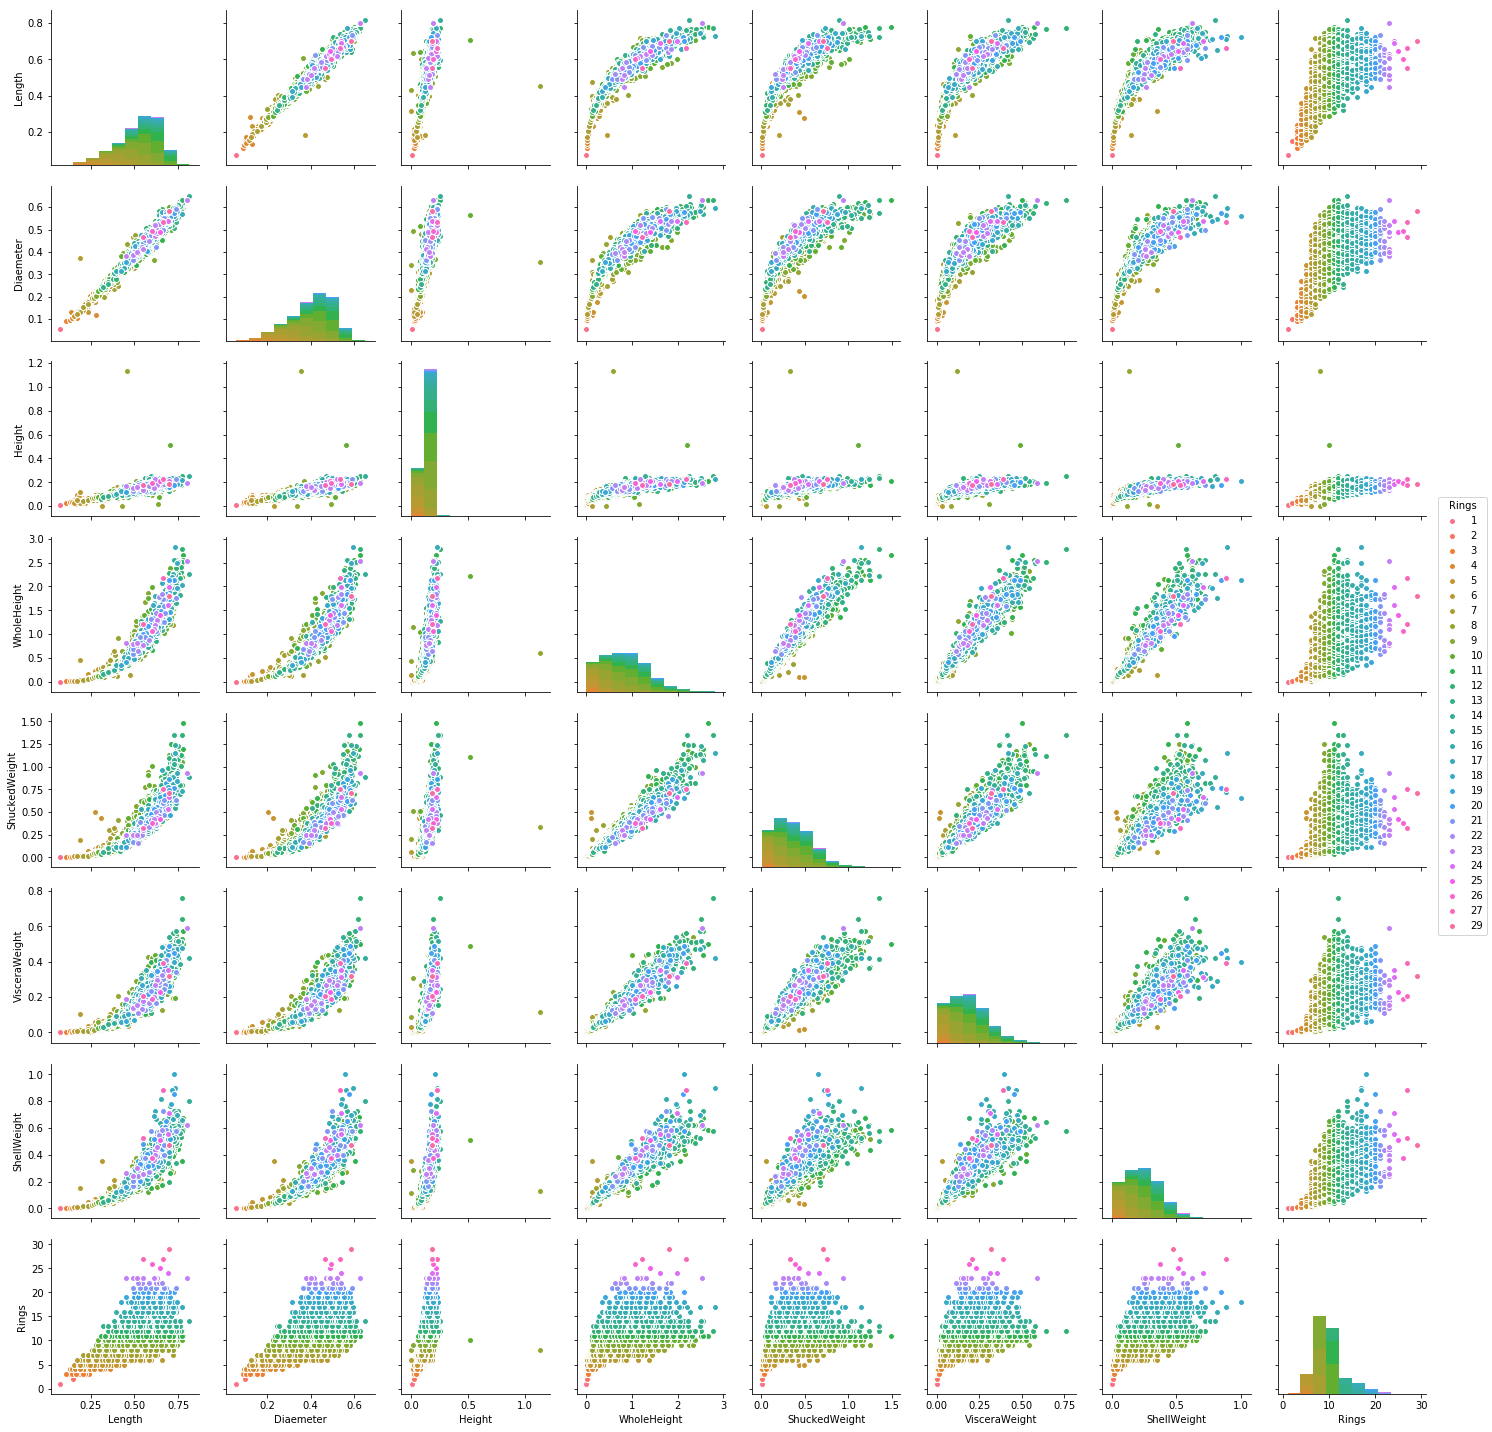

In [16]:
sns.pairplot(df, hue='Rings')

In [17]:
kf = KFold(n_splits=5)

isInit = False

for trainIndex, testIndex in kf.split(all_inputs):
    X_train, X_test = all_inputs[trainIndex], all_inputs[testIndex]
    y_train, y_test = all_classes[trainIndex], all_classes[testIndex]
    
    dt = build_dt(X=X_train, y=y_train,attribute_types=df.dtypes,options= None)
    predicts = predict_dt(dt,X_test, None)
    """
    print('X_train:',len(X_train),"X_test:",len(X_test))
    print('y_train:',len(y_train),"y_test:",len(y_test))
    print('Pred:',len(predicts))
    """    
    if not isInit:
        allActualValues = y_test
        allPredictedValues = predicts
        isInit=True
    else:
        allActualValues = np.concatenate((allActualValues,y_test))
        allPredictedValues = np.concatenate((allPredictedValues,predicts))

In [19]:
print(allActualValues.shape)
print(allPredictedValues.shape)

confMatrix = confusion_matrix(allActualValues,allPredictedValues)
print("ConfusionMatrix Accuracy:", calcConfusionMatrixAcc(confMatrix))


(4177,)
(4177,)
ConfusionMatrix Accuracy: 0.1970313622216902
